In [1]:
import torch
import torchvision                                                       
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose, Normalize
from torch.autograd import Variable
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os
import math

# آ

In [2]:
#values from https://boscoj2008.github.io/customCNN/
mean = 0.2859;  std = 0.3530 # calculated using standization from FashionMNIST
# Define a transform to normalize the data
transform = Compose([ToTensor(),
                    Normalize(mean,std)])
training_data = datasets.FashionMNIST(
    root="data", # the root directory to save the downloaded dataset
    train=True, 
    download=True,  
    transform= transform
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform= transform
)

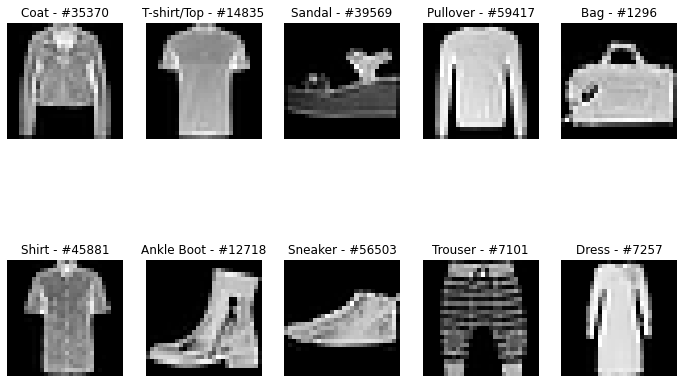

In [3]:
# Create de-transformer to be used while printing images
# PIL images loaded into dataset are normalized.
# In order to display them correctly we need to un-normalize them first
# If 'ToTensor' transformation was applied then the PIL images have CHW format.
# To show them using pyplot.imshow(), we need to change it to HWC with 
# permute() function.
def detransformer (img,mean=mean, std=std):
  un_normalizer = Normalize(-mean/std,1./std)
  img = un_normalizer(img)
  return img.permute(1,2,0)


# Translation between class id and name
class_dict = {
    0: "T-shirt/Top",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat", 
    5: "Sandal", 
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot"
}

# Helper function printing 10 random pictures from each class
def print_images():
  a = [-1]*10
  b = False
  j = int(0)
  fig = plt.figure()
  fig.set_size_inches(fig.get_size_inches() * 2)
  while b != True:
    i = torch.randint(0, len(training_data), (1,)).item()
    img, label = training_data[i]
    if a[label] == -1:
      j+=1
      a[label] = 1
      picture = detransformer(img)
      ax = plt.subplot(2, 5, j)
      ax.set_title(class_dict[label] + ' - #' + str(i))
      ax.axis('off')
      plt.imshow(picture.squeeze(),cmap='gray')
    if sum(a)==10:
      b = True
  plt.show()

print_images()

In [4]:
#Dataloaders
num_threads = 2     # Loading the dataset is using 4 CPU threads
batch_size  = 128   # Using minibatches of 128 samples

train_loader = DataLoader(dataset=training_data,
                          batch_size=batch_size,
                          shuffle=True,           
                          num_workers=num_threads)


test_loader = DataLoader(dataset=test_data,
                         batch_size=batch_size,
                         shuffle=True,
                         num_workers=num_threads)




In [5]:
print(f"The train set contains {len(train_loader.dataset)} images, in {len(train_loader)} batches.")
print(f"The test set contains {len(test_loader.dataset)} images, in {len(test_loader)} batches.")

The train set contains 60000 images, in 469 batches.
The test set contains 10000 images, in 79 batches.


# ب

In [6]:
def log_softmax(pred): #subtract max from all values to ensure stability
  m = torch.max(pred,-1, keepdim=True)[0]
  #return pred  -  pred.exp().sum(-1).log().unsqueeze(-1)
  return pred - m - (pred-m).exp().sum(-1,keepdim=True).log()

def cross_entropy (pred, target) : # LogSoftmax + NLLLoss
  pred_soft = log_softmax(pred)
  #using this form of calculation, one-hot encoded target values are not needed
  return -pred_soft[range(target.shape[0]), target].mean()

def relu(x): 
  return x.clamp(min=0.) - 0.5

def linear(x, w, b): 
  return x@w + b # @ is faster than matmul
  #return x.matmul(w) + b





In [10]:
#some ideas were taken from here https://towardsdatascience.com/steps-to-basic-modern-nn-model-from-scratch-1e86b7c042
# kaiming normalization
w1 = torch.randn((784,512),dtype=torch.double,requires_grad=True)*math.sqrt(2./784 )
b1 = torch.zeros(512,dtype=torch.double,requires_grad=True)
w2 = torch.randn((512,256),dtype=torch.double,requires_grad=True)*math.sqrt(2./512 )
b2 = torch.zeros(256,dtype=torch.double,requires_grad=True)
w3 = torch.randn((256,10),dtype=torch.double,requires_grad=True)*math.sqrt(2./256 )
b3 = torch.zeros(10,dtype=torch.double,requires_grad=True)

In [15]:
def model(xb,w1,b1,w2,b2,w3,b3):
  l1 = linear(xb, w1, b1)
  r1 = relu(l1)
  l2 = linear(r1, w2, b2)
  r2 = relu(l2)
  l3 = linear(r2,w3,b3)
  return log_softmax(l3)

# ج

In [16]:
lr = 1e-3
epochs = 100

train_losses, test_losses = [] , []

for epoch in range(epochs):
  print(f"Epoch {epoch+1}\n-------------------------------")

  #train loop-----------------------------------------------
  train_size = len(train_loader.dataset)
  train_batches = len(train_loader)
  train_loss, train_correct = 0, 0
  for batch, (x_train, y_train) in enumerate(train_loader):
    #forward
    # x_train = Variable(x_train.view(x_train.shape[0], -1)) #flatten data
    # y_train = Variable(y_train)

    x_train = x_train.view(x_train.shape[0], -1).to(torch.double) #flatten data
    pred = model(x_train,w1,b1,w2,b2,w3,b3)
    loss = cross_entropy(pred, y_train)
    loss.backward(retain_graph=True)
    

    #backward
    #with torch.no_grad(): # use SGD to update variables

    train_loss += loss.item()
    train_correct += (pred.argmax(1) == y_train).type(torch.float).sum().item()

    w1_g, w2_g, w3_g = w1.grad, w2.grad, w3.grad
    b1_g, b2_g, b3_g = b1.grad, b2.grad, b3.grad

    w1 = w1.detach()
    w1 -= w1_g * lr
    w1 = w1.requires_grad_()
    b1 = b1.detach()
    b1 -= b1_g * lr
    b1 = b1.requires_grad_()

    w2 = w2.detach()
    w2 -= w2_g * lr
    w2 = w2.requires_grad_()
    b2 = b2.detach()
    b2 -= b2_g * lr
    b2 = b2.requires_grad_()

    w3 = w3.detach()
    w3 -= w3_g * lr
    w3 = w3.requires_grad_()
    b3 = b3.detach()
    b3 -= b3_g * lr
    b3 = b3.requires_grad_()

    # w1 -= w1.grad * lr
    # b1 -= b1.grad * lr
    # w1.grad.zero_()
    # b1.grad.zero_()

    # w2 -= w2.grad * lr
    # b2 -= b2.grad * lr
    # w2.grad.zero_()
    # b2.grad.zero_()

    # w3 -= w3.grad * lr
    # b3 -= b3.grad * lr
    # w3.grad.zero_()
    # b3.grad.zero_()


    
  train_loss /= train_batches
  train_correct /= train_size
  print(f"Train Error: \n Accuracy: {(100*train_correct):>0.1f}%, Avg loss: {train_loss:>8f} \n")
  train_losses.append(train_loss)


  #test loop-----------------------------------------------
  test_size = len(test_loader.dataset)
  test_batches = len(test_loader)
  test_loss, test_correct = 0, 0
 

  with torch.no_grad(): 

    for batch, (x_test, y_test) in enumerate(test_loader):
      #forward
      x_test = x_test.view(x_test.shape[0], -1).to(torch.double) #flatten data
      #x_test, y_test = x_test.to(device), y_test.to(device)

      pred = model(x_test,w1,b1,w2,b2,w3,b3)
      test_loss += cross_entropy(pred, y_test).item()
      test_correct += (pred.argmax(1) == y_test).type(torch.float).sum().item()

  test_loss /= test_batches
  test_correct /= test_size
  print(f"Test Error: \n Accuracy: {(100*test_correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
  test_losses.append(test_loss)


Epoch 1
-------------------------------


RuntimeError: ignored